# A Credit Rating Example

*by Rüdiger Ehlers, Jörg Grieser, Christoph Knieke, Andreas Rausch, Mirco Schindler*

This example shows how the combination of 

1. the integration of sanity conditions for reasonableness for machine-learned models and
2. formal verification

can help with machine-learning models whose behavior is understandable.

This Jupyter notebook can be downloaded from https://example.safeml.de/PartiallyMonotoneCreditRating.ipynb. 

In order to run it, you need Python 3, jupyter, pytorch, matplotlib, and seaborn installed. Additionally, two repositories from Github need to be checked out.

1. The repository https://github.com/progirep/convex_adversarial.git needs to be checked out into the directory "convex_adversarial" in the directory of this notebook. It provides functions for neural network layers that behave like linear layers, but can internally have a more complicated structure. The new layer types defined in this notebook use a base class from that repository.
2. The repository https://github.com/progirep/planet needs to be checked out into the directory "planet" in the directory of this notebook. It provides the neural network verification tool *planet*, which is called at the end of this notebook. It comes with a README file that details how to build the tool (under Linux).

The notebook has only been tested under Linux. Using the version control software *git*, the repositories from Github can be checked out with the command "git clone <url\>" (while being in the directory in which this jupyter notebook is located).

## 1. Import Python libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import matplotlib
import seaborn
import matplotlib.patches as patches
import subprocess
from scipy.spatial import HalfspaceIntersection

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

import numpy as np

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 2. Define a data set for this example

In [2]:
CATEGORIES = ["Defaulted","Missed Some\nPayments","Fair Debtor","Optimal Debtor"]

# All data points consist of
# 1. Yearly income in EUR
# 2. Number of years in the company
# 3. Credit worthiness category
DATA = [(25000,4,0),
        (20000,12,0),
        (15000,1,0),
        (20000,17,0),
        (18000,28,0),
        (16000,30,0),
        (21000,15,0),
        (22000,12,0),
        (24000,9,0),
        (19000,6,0),
        (21000,2,0),
        (35000,7,1),
        (25000,14,1),
        (28000,5,1),
        (29000,17,1),
        (19000,12,1),
        (37000,14,1),
        (42000,15,1),
        (29000,11,1),
        (34000,7,1),
        (28000,3,1),
        (31000,2,1),
        (41500,18,2),
        (45000,19,2),
        (34000,21,2),
        (59000,3,2),
        (49000,2,2),
        (41000,7,2),
        (44000,15,2),
        (37000,11,2),
        (45000,7,2),
        (49000,19,2),
        (39000,5,2),
        (51500,18,3),
        (55000,19,3),
        (44000,21,3),
        (39000,3,3),
        (49000,2,3),
        (31000,4,3),
        (44000,11,3),
        (37000,18,3),
        (35000,27,3),
        (42000,29,3),
        (39000,9,3),
       ]

## 3. Translate data set to format required for machine learning
Also normalize the data set while we are at it.

In [3]:
# Compute minimum/maximum values for all dimensions of the data
minValues = [min([a[i] for a in DATA]) for i in range(0,len(DATA[0]))]
maxValues = [max([a[i] for a in DATA]) for i in range(0,len(DATA[0]))]
NORMALIZED_DATA = [[(a[i]-minValues[i])/(maxValues[i]-minValues[i]) for i in range(0,len(DATA[0]))] for a in DATA]

# Translate into a form useful for learning
X = torch.Tensor(np.array([(a[0],a[1]) for a in NORMALIZED_DATA]))
Y = torch.Tensor(np.array([(a[2]) for a in DATA])).long()

## 4. Draw the data set


In [4]:
# Define a function for drawing a graph/dataset
def drawGraph(net, markedPoint=None,verticalLines=[]):
    XX, YY = np.meshgrid(np.linspace(-0.04, 1.04, 1200,endpoint=True), np.linspace(-0.04, 1.04, 1200,endpoint=True))
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    fig, ax = plt.subplots(figsize=(12,8))
    cmap = matplotlib.cm.get_cmap('Accent')

    # Draw the classifier (if given)
    if not net is None:
        y0 = net(X0)
        ZZ = (np.argmax(np.stack([y0[:,a].detach().numpy() for a in range(0,y0.size()[1])]),axis=0))
        ZZ.resize(1200,1200)
        ZZ[0][0] = 0
        ZZ[0][1] = 1
        ZZ[0][2] = 2
        ZZ[0][3] = 3
        ax.contourf(XX,YY,-ZZ, cmap=cmap)

    # Draw the input data
    for c in [0,1,2,3]:
        X2 = torch.Tensor(np.array([(a[0],a[1]) for i,a in enumerate(NORMALIZED_DATA) if DATA[i][2]==c]))
        Y2 = [c for i,a in enumerate(NORMALIZED_DATA) if DATA[i][2]==c]
        ax.scatter(X2.numpy()[:,0], X2.numpy()[:,1], c=[cmap(7),cmap(5),cmap(2),cmap(0)][c], 
                   s=70, label=CATEGORIES[c],linewidths=[1],edgecolor="black")
        
    # Vertical lines?
    for v in verticalLines:
        plt.plot([-0.04, 1.04], [(v-minValues[1])/(maxValues[1]-minValues[1])]*2, color='k', linestyle='--', linewidth=2)

    # Marked point?
    if not markedPoint is None:
        plt.scatter(markedPoint[0],markedPoint[1],marker='X',s=200)
        
    # Axis ticks and labels
    ax.axis([-0.02,1.02,-0.02,1.02])
    plt.legend()

    moneyTicks = [15000,25000,40000,50000,60000]
    plt.xticks([(a-minValues[0])/(maxValues[0]-minValues[0]) for a in moneyTicks],
               [str(a) for a in moneyTicks])
    plt.xlabel("Income (EUR) / Year")

    yearsTicks = [5,10,20,30]
    plt.yticks([(a-minValues[1])/(maxValues[1]-minValues[1]) for a in yearsTicks],
               [str(a) for a in yearsTicks])
    plt.ylabel("Years")
    


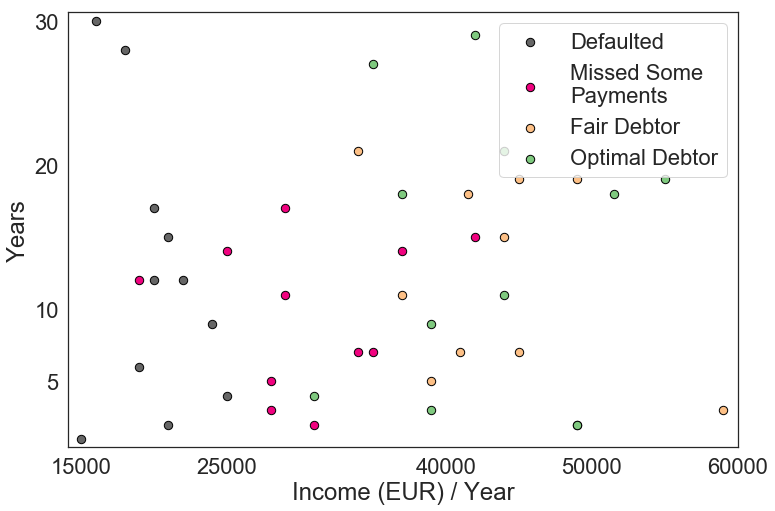

In [5]:
drawGraph(None)
plt.savefig('inputData.pgf',bbox_inches='tight')

## 5. Learn a standard classifier

In [6]:
def learnNetwork(net,iterations,learning_rate=0.05):
    
    # opt = optim.Adam(net.parameters(), lr=learning_rate)
    opt = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.0)
    for i in range(iterations):
        out = net(Variable(X))
        l = nn.CrossEntropyLoss()(out, Variable(Y))
        err = (out.max(1)[1].data != Y).float().mean()
        if i % (iterations // 10) == 0:
            print("Current loss:",l.data.item(), "\tCurrent classification error:",err.item())
        opt.zero_grad()
        (l).backward()
        opt.step()
    print("Current loss:",l.data.item(), "\tCurrent classification error:",err.item())


np.random.seed(123)
torch.manual_seed(123)

netClassic = nn.Sequential(
    nn.Linear(2,50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,4)
)

learnNetwork(netClassic,90000,learning_rate=0.2)

Current loss: 1.387151837348938 	Current classification error: 0.75
Current loss: 0.04171157255768776 	Current classification error: 0.022727273404598236
Current loss: 0.03165900707244873 	Current classification error: 0.022727273404598236
Current loss: 0.03156829625368118 	Current classification error: 0.022727273404598236
Current loss: 0.03154285252094269 	Current classification error: 0.022727273404598236
Current loss: 0.031533777713775635 	Current classification error: 0.022727273404598236
Current loss: 0.03152908384799957 	Current classification error: 0.022727273404598236
Current loss: 0.03152240440249443 	Current classification error: 0.022727273404598236
Current loss: 0.031521886587142944 	Current classification error: 0.022727273404598236
Current loss: 0.03151948004961014 	Current classification error: 0.022727273404598236
Current loss: 0.031519729644060135 	Current classification error: 0.022727273404598236


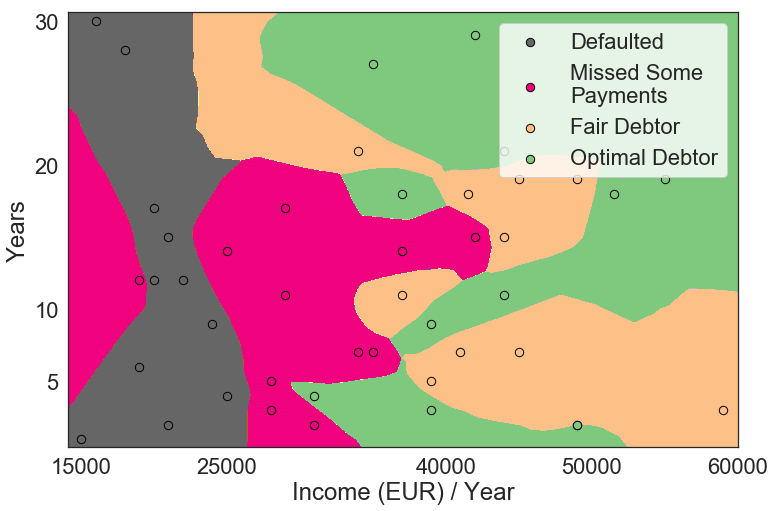

In [7]:
drawGraph(netClassic)
plt.savefig('nonMonotoneClassification.pgf',bbox_inches='tight')

While the classification accurracy is quite good, this learned model makes little sense. There is no reason to believe that the learned model is a good predictor in general.

## 6. Learn a partially monotone classifier

First, we define a *monotone* layer

In [8]:
import sys
import convex_adversarial
import math

class MonotoneLinear(convex_adversarial.LinearLikeLayer):
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.out_features = out_features
        self.in_features = in_features
        self.myweight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.mybias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('mybias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.myweight.size(1))
        self.myweight.data.uniform_(-stdv, stdv)
        if self.mybias is not None:
            self.mybias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return torch.nn.functional.linear(input, self.getWeight(), self.getBias())

    def getWeight(self):
        return torch.clamp(self.myweight,min=0.00)
    
    def getBias(self):
        return self.mybias
    


class MonotoneClassifierManyFeaturesSort(convex_adversarial.LinearLikeLayer):
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.out_features = out_features
        self.in_features = in_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def getWeight(self):
        return torch.sort(self.weight, 0)[0]
    
    def getBias(self):
        return torch.sort(self.bias, 0, True)[0]

Now, let's define a useful architecture for this case.

In [9]:
class SplittingNetwork(torch.nn.Module):
    def __init__(self,partASize,partBSize):
        super().__init__()
        self.partASize = partASize
        self.partBSize = partBSize
    

class SplittingNetworkA(SplittingNetwork):
    
    def __init__(self):
        super().__init__(1,1)
        
        # Proc B
        self.procB = torch.nn.Sequential(nn.Linear(1,15),
            nn.ReLU(),
            nn.Linear(15,15),
            nn.ReLU(),
            # nn.Linear(20,20),
        )
        
        # Joint C
        self.procA = torch.nn.Sequential(MonotoneLinear(1,15),
            nn.ReLU(),
            MonotoneLinear(15,15),
            nn.ReLU(),
            )
        
        self.finalComponent = torch.nn.Sequential(MonotoneLinear(30,20),
            nn.ReLU(),
            MonotoneLinear(20,20),
            nn.ReLU(),
            # MonotoneLinear(20,20),
            MonotoneClassifierManyFeaturesSort(20,4)
        )

    def forward(self, input):
        
        parts = input.split([1,1],dim=1)
        
        trackA = self.procA(parts[0])        
        trackB = self.procB(parts[1])
        
        tracks = torch.cat((trackA,trackB),dim=1)
        tracks = self.finalComponent(tracks)
        
        return tracks

np.random.seed(123)
torch.manual_seed(123)
splitNet = SplittingNetworkA()

learnNetwork(splitNet,90000,learning_rate=0.02)

Current loss: 1.571234107017517 	Current classification error: 0.75
Current loss: 0.6614300608634949 	Current classification error: 0.34090909361839294
Current loss: 0.6378275156021118 	Current classification error: 0.2954545319080353
Current loss: 0.5514742732048035 	Current classification error: 0.25
Current loss: 0.5197911858558655 	Current classification error: 0.27272728085517883
Current loss: 0.4352434277534485 	Current classification error: 0.22727273404598236
Current loss: 0.41017648577690125 	Current classification error: 0.1818181872367859
Current loss: 0.4442286193370819 	Current classification error: 0.1818181872367859
Current loss: 0.4071870744228363 	Current classification error: 0.15909090638160706
Current loss: 0.37425851821899414 	Current classification error: 0.15909090638160706
Current loss: 0.34318044781684875 	Current classification error: 0.15909090638160706


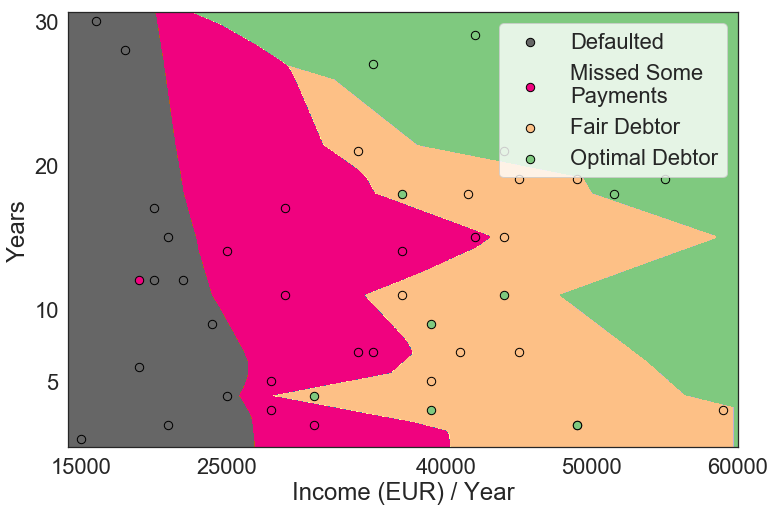

In [10]:
drawGraph(splitNet)
plt.savefig('monotone.pgf',bbox_inches='tight')

Let us now perform some sanity checks.

## 7. Analyze the learned model

### 7.1 What is the minimum yearly income that always puts employees with 5-10 years of company membership into the best category?

In [11]:
# Function for connecting to external SMT solver

def recurse_write_network_as_rlv(net,outFile,last_layer,nofLayersSoFar):
    
    if isinstance(net,torch.nn.Sequential):
        for child in net.children():
            last_layer,nofLayersSoFar = recurse_write_network_as_rlv(child,outFile,last_layer,nofLayersSoFar)
    elif isinstance(net,torch.nn.modules.linear.Linear):
        # Linear layer
        this_layer = ["ip"+str(nofLayersSoFar)+"X"+str(j) for j in range(0,net.out_features)]
        allParams = list(net.parameters())
        assert len(allParams)==2
        definitionLines = ["Linear "+a+" "+str(allParams[1][i].item()) for i,a in enumerate(this_layer)]
        for i,vector in enumerate(allParams[0]):
            for j,value in enumerate(vector):
                definitionLines[i] = definitionLines[i] + " "+str(value.item())+" "+last_layer[j]           
        last_layer = this_layer
        print("\n".join(definitionLines),file=outFile)
        nofLayersSoFar += 1
    elif isinstance(net,convex_adversarial.LinearLikeLayer):
        # Linear layer
        this_layer = ["ip"+str(nofLayersSoFar)+"X"+str(j) for j in range(0,net.out_features)]
        definitionLines = ["Linear "+a+" "+str(net.getBias()[i].item()) for i,a in enumerate(this_layer)]
        for i,vector in enumerate(net.getWeight()):
            for j,value in enumerate(vector):
                definitionLines[i] = definitionLines[i] + " "+str(value.item())+" "+last_layer[j]           
        last_layer = this_layer
        print("\n".join(definitionLines),file=outFile)
        nofLayersSoFar += 1
    
    elif isinstance(net,torch.nn.modules.activation.ReLU):
        this_layer = ["relu"+str(nofLayersSoFar)+"X"+str(j) for j in range(0,len(last_layer))]
        allParams = list(net.parameters())
        assert len(allParams)==0
        for i,a in enumerate(this_layer):
            print("ReLU "+str(a)+" 0.0 1.0 "+last_layer[i],file=outFile)
        last_layer = this_layer
        nofLayersSoFar += 1
        
    elif isinstance(net,torch.nn.modules.activation.LeakyReLU):
        next_layer = ["relu"+str(nofLayersSoFar)+"X"+str(j) for j in range(0,len(last_layer))]
        allParams = list(net.parameters())
        assert len(allParams)==0
        for i,a in enumerate(next_layer):
            print("ReLU "+str(a)+" 0.0 1.0 "+last_layer[i],file=outFile)
            
        # Linear combination
        next_next_layer = ["leaky"+str(nofLayersSoFar)+"X"+str(j) for j in range(0,len(last_layer))]
        for i,a in enumerate(next_next_layer):
            print("Linear "+str(a)+" 0.0 1.0 "+next_layer[i]+" "+str(net.negative_slope)+" "+last_layer[i],file=outFile)
        
        last_layer = next_next_layer
        nofLayersSoFar += 2
        
    elif isinstance(net,SplittingNetwork):
        partA = last_layer[0:net.partASize]
        partB = last_layer[net.partASize:]
        assert net.partASize+net.partBSize==len(last_layer)
        partA,nofLayersSoFar = recurse_write_network_as_rlv(net.procA,outFile,partA,nofLayersSoFar)
        partB,nofLayersSoFar = recurse_write_network_as_rlv(net.procB,outFile,partB,nofLayersSoFar)
        last_layer = partA+partB
        nofLayersSoFar += 3
        last_layer,nofLayersSoFar = recurse_write_network_as_rlv(net.finalComponent,outFile,last_layer,nofLayersSoFar)
    else:
        raise Exception("Unsupported layer type: ",net)

    return (last_layer,nofLayersSoFar)


def write_network_as_rlv(net
                         ,rlvName,nofInputValues):
    
    # 1. Write output file
    with open(rlvName,"w") as outFile:
        done = False
        last_layer = []
        for i in range(0,nofInputValues):
            last_layer.append("inX"+str(i))
            print("Input",last_layer[-1],file=outFile)
        last_layer, nofLayers = recurse_write_network_as_rlv(net,outFile,last_layer,1)
    return last_layer

# What is the least amount of money needed to get an optimal credit rating (within 1%)
minMoney = 0.0
maxMoney = 1.0
bestPoint = [0,0]
while (maxMoney-minMoney)>0.00001:
    
    # Do a bisection search step
    midMoney = (maxMoney+minMoney)/2.0
    
    lastLayer = write_network_as_rlv(splitNet,"credit.rlv",2)
    with open("credit.rlv","a") as outFile:
        outFile.write("Assert >= 1 1.0 inX0\n")
        outFile.write("Assert <= 0 1.0 inX0\n")
        outFile.write("Assert >= "+str((10-minValues[1])/(maxValues[1]-minValues[1]))+" 1.0 inX1\n")
        outFile.write("Assert <= "+str((5-minValues[1])/(maxValues[1]-minValues[1]))+" 1.0 inX1\n")
        outFile.write("Assert <= 0.0 -1.0 "+lastLayer[3]+" 1.0 "+lastLayer[2]+"\n")
        outFile.write("Assert <= "+str(midMoney)+" 1.0 inX0\n")
        
    with subprocess.Popen("planet/src/planet credit.rlv",shell=True,stdout=subprocess.PIPE,stderr=subprocess.DEVNULL) as checker:
        foundResult = True
        isSAT = False
        for line in checker.stdout.readlines():
            line = line.decode("utf-8")
            if line.startswith("SAT"):
                minMoney = midMoney
                isSAT = True
            elif line.startswith("UNSAT"):
                maxMoney = midMoney
            if isSAT:
                if line.startswith("- inX0:"):
                    bestPoint[0] = float(line.split(" ")[2])
                elif line.startswith("- inX1:"):
                    bestPoint[1] = float(line.split(" ")[2])
        assert checker.wait()==0
        
print("Result (Yearly income):",bestPoint[0]*(maxValues[0]-minValues[0])+minValues[0])
print("Result (Years of service in the compary):",bestPoint[1]*(maxValues[1]-minValues[1])+minValues[1])


Result (Yearly income): 55233.864
Result (Years of service in the compary): 5.000289


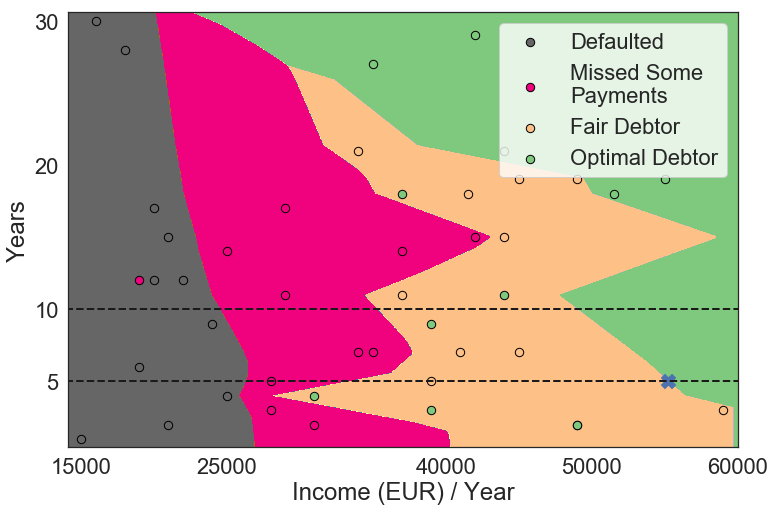

In [12]:
d = drawGraph(splitNet,bestPoint,verticalLines=[5,10])
plt.savefig('monotoneMark.pgf',bbox_inches='tight')